## Re-calculate market access to compare added access from regional cities.
Use Mapbox API to calcuate travel time to major domestic and neighboring cities (population greater than 50k).  
Use district centroids as origins.  
Run market access calculation again.  

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from shapely.wkt import loads
import glob

In [4]:
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
iso = 'ARG'
data_dir = f'/home/public/Data/PROJECTS/INFRA_SAP/{iso}'
raster_path = os.path.join(data_dir, 'WP_2020_1km.tif')
output_path = os.path.join(os.path.expanduser("~"),'data/argentina')
target = gpd.read_file(os.path.join(data_dir, 'admin.shp'))
urban_extents = os.path.join(data_dir, 'urban_extents.shp')

In [5]:
target['centroid'] = target.centroid

In [6]:
cities = gpd.read_file(global_cities)
adm0 = gpd.read_file(global_admin)
adm0 = adm0.loc[adm0.is_valid]
cities = gpd.sjoin(cities, adm0[['ADM0_NAME','geometry']], how='left')

In [5]:
# border_countries = ['Argentina', 'Brazil', 'Paraguay']

In [8]:
pop_thresh = 50000
dist_thresh = 100000 # meters

In [9]:
cities = cities[cities.Pop>pop_thresh].copy()

In [10]:
cities_proj = cities.to_crs('EPSG:32721') # mercator 3857
target_proj = target.to_crs('EPSG:32721')

In [11]:
target_buffer = target_proj.buffer(dist_thresh)

In [12]:
# buffer_gdf = gpd.GeoDataFrame(geometry=[target_buffer.unary_union], crs=target.crs)
# buffer_gdf.to_csv(os.path.join(output_path,"buffer.csv"))

In [13]:
cities_filter = cities_proj[cities_proj.intersects(target_buffer.unary_union)]

In [14]:
cities_filter.ADM0_NAME.value_counts()

Argentina    49
Chile         7
Brazil        3
Paraguay      3
Uruguay       1
Bolivia       1
Name: ADM0_NAME, dtype: int64

In [15]:
cities_filter = cities_filter[cities_filter.ADM0_NAME!="Argentina"].copy()

In [16]:
cities_filter = cities_filter.to_crs(cities.crs)

In [18]:
cities_arg = gpd.read_file(urban_extents)

In [20]:
cities_arg = cities_arg[cities_arg.Pop>pop_thresh].copy()

In [22]:
cities_filter.crs == cities_arg.crs

True

In [23]:
cities_concat = pd.concat([cities_filter, cities_arg]).reset_index(drop=True)

In [24]:
# cities_filter.to_csv(os.path.join(output_path, "cities_buffer.csv"))

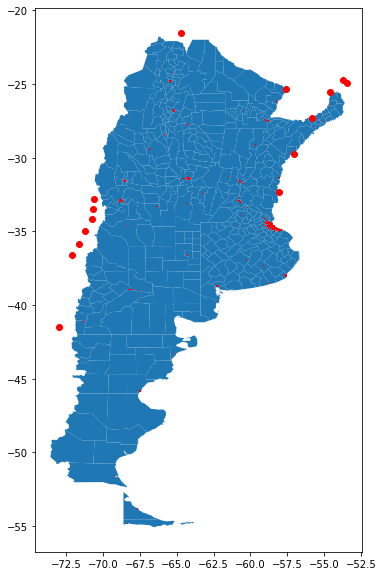

In [27]:
ax = target.plot(figsize=(10, 10))
cities_concat.plot(figsize=(10, 10), ax=ax, color='red')

In [28]:
target.crs == cities_concat.crs

True

In [39]:
origins = target.copy()
dests = cities_concat.copy().reset_index(drop=True)

In [48]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

In [49]:
dests['x'] = dests.centroid.x
dests['y'] = dests.centroid.y

In [50]:
origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

In [51]:
origins_sel = origins.loc[:,["ID","x","y"]]
dests_sel = dests.loc[:,["ID","x","y"]]

In [38]:
origins_sel['Pop'] = 1
dests_sel['Pop'] = 1

In [52]:
os.getcwd()

'/home/wb514197/scripts/argentina'

In [53]:
origins_sel.to_csv("origins2.csv")
dests_sel.to_csv("dests_50k.csv")

In [54]:
import json, sys, os, time, argparse, logging
import shapely

import pandas as pd
import numpy as np
import urllib.request as url

In [55]:
MB_Toke = '' # get from mapbox account

In [56]:
def CreateODMatrix(infile, infile_2, lat_name = 'Lat', lon_name = 'Lon', UID = 'ID', 
                    Pop = 'Pop', call_type = 'OSRM', rescue = 0, rescue_num = 0, MB_Toke = '', 
                    sleepTime = 5, osrmHeader = ''):
    '''
    TODO: make the function flexible for MapBox endpoint - add back MB token / different formatting
    '''
    ffpath = os.path.dirname(infile)
    start = time.time()
    print('\nChosen server: %s\n\nStart time: %s' % (call_type, time.ctime(start)))
    print('Origins: %s' % infile)
    print('Destinations: %s\n' % infile_2)

    # Save settings
    save_rate = 5
    def save(returns, j, i, numcalls, rescue_num):
        elapsed_mins = (time.time() - start)/60
        elapsed_secs = (time.time() - start)%60
        total = ((numcalls / float(i)) * (time.time() - start)/60.0)
        remaining = total - elapsed_mins
        print ('\n______________________________________\n')
        print ('\nSave point %s. Running for: %d minutes %d seconds' % (j, elapsed_mins, elapsed_secs))
        print ('\ncalls completed: %d of %d. Est. run time: %d minutes. Time remaining: %d' % (i-1, numcalls, total, remaining))
        print ('\npercentage complete: %d percent' % (((i-1) / float(numcalls)*100)))
        print ('\n______________________________________\n')
        try:
            df = pd.concat(returns)
        except:
            df = returns
        curOutput = os.path.join(ffpath,'temp_file_%d.csv' % rescue_num)
        df.to_csv(curOutput)
        
        
    # Function for calling OSRM server.
    def Call(O_list, D_list, i, O_IDs, D_IDs, header):
        # Convert origins to HTTP request string
        Os = ';'.join(str(coord).replace("'", "").replace(";", "") for coord in O_list)
        # Destinations to HTTP request string
        Ds = ';'.join(str(coord).replace("'", "").replace(";", "") for coord in D_list)
        # Join them together
        data = Os+';'+Ds

        # Define which coords in data string are origins, and which are destinations
        sources = ['%d' % x for x in range(0,len(O_list))]
        sources = ';'.join(str(x).replace("'", "") for x in sources)
        lenth = len(O_list)+len(D_list)
        destinations = ['%d' % x for x in range(len(O_list),lenth)]
        destinations = ';'.join(str(x).replace("'", "") for x in destinations)

        # Build request string
        request = header+data+'?sources='+sources+'&destinations='+destinations+'?&access_token='+MB_Toke
        # Pass request to interweb
        
        try:
            r = url.urlopen(request)
        except:
            print(request)
            time.sleep(5)
            r = url.urlopen(request)
            
        # Error handle
        try:
            # Convert Bytes response to readable Json
            MB_TelTest_json = json.loads(r.read().decode('utf-8'))
            data_block = MB_TelTest_json['durations']
        except:
            data_block = 'null'

        # Build df from JSON
        #sources_label = [str(i['location']) for i in MB_TelTest_json['sources']]
        #dest_label = [str(i['location']) for i in MB_TelTest_json['destinations']]
        sources_label = O_IDs
        dest_label = D_IDs
        chunk = pd.DataFrame(data = data_block, columns = dest_label, index = sources_label)
        # Convert to minutes, stack 2D array to 1D array
        chunk = chunk.stack(level =-1)
        chunk.columns = ['O','D','DIST']
        return(chunk)

    # Generate appropriately split source and destination lists
    def split_and_bundle(in_list,break_size):
        new_list = []
        for i in range (0,(int(max(len(in_list)/break_size,1)))):
            upper = (i+1) * break_size
            lower = (upper - break_size)
            objs = in_list[lower:upper]
            new_list.append(objs)
        if len(in_list) > break_size:
            rem = len(in_list) % break_size
            if rem > 0:
                final = upper+rem
                new_list.append(in_list[upper:final])
        return new_list

    # File Import for sources file
    input_df = pd.read_csv(infile)
    input_df['source_list'] = input_df[lon_name].map(str).str.cat(input_df[lat_name].map(str), sep = ',')
    input_df['source_list'] = input_df['source_list']+';'
    source_list = input_df['source_list'].values.tolist()
    source_UIDs = input_df[UID].values.tolist()
    #input_df['source_point'] = input_df.apply(lambda x: Point(x[lon_name],x[lat_name]), axis = 1)
    #source_points = input_df['source_point'].tolist()

    # Look to import separate file for destinations; if not, set destinations = sources
    input_df2 = pd.read_csv(infile_2)
    input_df2['dest_list'] =  input_df2[lon_name].map(str).str.cat(input_df2[lat_name].map(str), sep = ',')
    input_df2['dest_list'] = input_df2['dest_list']+';'
    dest_list = input_df2['dest_list'].values.tolist()
    dest_UIDs = input_df2[UID].values.tolist()           

    if call_type == 'MBT' :
        sources_list = split_and_bundle(source_list, 5)
        dests_list = split_and_bundle(dest_list, 5)
        sources_UIDs = split_and_bundle(source_UIDs, 5)
        dests_UIDs = split_and_bundle(dest_UIDs, 5)
    elif call_type == 'MB'or call_type == 'OSRM':
        sources_list = split_and_bundle(source_list, 12)
        dests_list = split_and_bundle(dest_list, 13)
        sources_UIDs = split_and_bundle(source_UIDs, 12)
        dests_UIDs = split_and_bundle(dest_UIDs, 13)
    else:
        pass
            
    # Run function call across the O-D matrix; output is 'df'
    returns = []
    numcalls = (len(sources_list) * len(dests_list))
    s , d = sources_list, dests_list
    i, j = 1 + (rescue * len(sources_list)), 1 + rescue

    ### Making Calls 
    if call_type == 'Euclid':
        df = EuclidCall(source_list,dest_list,source_points,dest_points)
    else:
        if rescue > 0:
            s = s[rescue:] # possibly rescue -1
            sources_UIDs = sources_UIDs[rescue:]
        print('source list: %s' % len(source_list))
        print('sources list: %s' % len(sources_list))
        print('dest list: %s' % len(dest_list))
        print('dests list: %s' % len(dests_list))
        numcalls_rem = (len(s) * len(d))
        print('\nEstimated remaining calls to chosen server: %d\n' % numcalls_rem)
        print('save points will occur every %d calls\n' % (len(dests_list)))
        if sleepTime > 0:
            time.sleep(sleepTime)
        for O_list in s:
            O_IDs = sources_UIDs[s.index(O_list)]
            for D_list in d:                    
                if sleepTime > 0:
                    time.sleep(sleepTime)
                D_IDs = dests_UIDs[d.index(D_list)]
                if call_type == 'MB':
                    header = 'https://api.mapbox.com/directions-matrix/v1/mapbox/driving/'
                elif call_type == 'MBT':
                    header = 'https://api.mapbox.com/directions-matrix/v1/mapbox/driving-traffic/'
                elif call_type == 'OSRM':
                    header = 'http://router.project-osrm.org/table/v1/driving/'
                    if osrmHeader != '':
                        header = osrmHeader
                try:
                    # prevent server annoyance
                    print('Call to OSRM server number: %d of %s' % (i, numcalls_rem))                
                    returns.append(Call(O_list,D_list,i,O_IDs,D_IDs, header))
                    i += 1
                    j += 1
                except:
                    logging.warning("Error Processing OSRM for i:%s and j:%s" % (i, j))
                    save(returns, j, i, numcalls, rescue_num)
        try:
            df = pd.concat(returns)
        except:
            df = returns

    # re-attach the population of origins and destinations, prep dataframe
    all_matrices = []
    if rescue_num > 0:
        for r in range(0,rescue_num):
            rescued_matrix = pd.read_csv(os.path.join(ffpath,'temp_file_%d.csv' % (r)),header=None)
            rescued_matrix.columns = ['O_UID','D_UID','DIST']
            all_matrices.append(rescued_matrix)
    df = df.reset_index()
    df.columns = ['O_UID','D_UID','DIST']
    all_matrices.append(df)
    new = pd.concat(all_matrices)
    try:
        new = new.set_index('O_UID')
        new['DIST'] = new['DIST'].apply(pd.to_numeric)
        popdf = input_df[[UID,Pop]].set_index(UID)
        new['O_POP'] = popdf[Pop]
        new = new.reset_index()
        new = new.set_index('D_UID')
        if dest_list == source_list:
            new['D_POP'] = popdf[Pop]
            new = new.reset_index()
        else:
            popdf_dest = input_df2[[UID,Pop]].set_index(UID)
            new['D_POP'] = popdf_dest[Pop]
            new = new.reset_index()
        new['O_UID'] = new['O_UID'].astype(str)
        new['D_UID'] = new['D_UID'].astype(str)
        new['combo'] = new['O_UID']+'_X_'+new['D_UID']
        new = new.drop_duplicates('combo')
        new = new.drop(['combo'], axis = 1)

        return new
    except:
        print("Something went wrong with processing population information, returning results without population results")
        return new

In [57]:
odRes = CreateODMatrix('origins2.csv', 'dests_50k.csv', lat_name = 'y', lon_name = 'x', UID = 'ID', 
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = 'pk.eyJ1IjoiZmVyY2hvc2lsdmEiLCJhIjoiY2s0MDM3c3IzMGNmMTNqbndza21vNXVxbiJ9.ap8UNe_LwH8IBgO0SnT1fA', 
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Tue Jun  2 16:49:47 2020
Origins: origins2.csv
Destinations: dests_50k.csv

source list: 513
sources list: 43
dest list: 66
dests list: 6

Estimated remaining calls to chosen server: 258

save points will occur every 6 calls

Call to OSRM server number: 1 of 258
Call to OSRM server number: 2 of 258
Call to OSRM server number: 3 of 258
Call to OSRM server number: 4 of 258
Call to OSRM server number: 5 of 258
Call to OSRM server number: 6 of 258
Call to OSRM server number: 7 of 258
Call to OSRM server number: 8 of 258
Call to OSRM server number: 9 of 258
Call to OSRM server number: 10 of 258
Call to OSRM server number: 11 of 258
Call to OSRM server number: 12 of 258
Call to OSRM server number: 13 of 258
Call to OSRM server number: 14 of 258
Call to OSRM server number: 15 of 258
Call to OSRM server number: 16 of 258
Call to OSRM server number: 17 of 258
Call to OSRM server number: 18 of 258
Call to OSRM server number: 19 of 258
Call to OSRM server number: 2

Call to OSRM server number: 229 of 258
Call to OSRM server number: 230 of 258
Call to OSRM server number: 231 of 258
Call to OSRM server number: 232 of 258
Call to OSRM server number: 233 of 258
Call to OSRM server number: 234 of 258
Call to OSRM server number: 235 of 258
Call to OSRM server number: 236 of 258
Call to OSRM server number: 237 of 258
Call to OSRM server number: 238 of 258
Call to OSRM server number: 239 of 258
Call to OSRM server number: 240 of 258
Call to OSRM server number: 241 of 258
Call to OSRM server number: 242 of 258
Call to OSRM server number: 243 of 258
Call to OSRM server number: 244 of 258
Call to OSRM server number: 245 of 258
Call to OSRM server number: 246 of 258
Call to OSRM server number: 247 of 258
Call to OSRM server number: 248 of 258
Call to OSRM server number: 249 of 258
Call to OSRM server number: 250 of 258
Call to OSRM server number: 251 of 258
Call to OSRM server number: 252 of 258
Call to OSRM server number: 253 of 258
Call to OSRM server numbe

In [58]:
odRes.tail()

,D_UID,DIST
O_UID,,
3025,65,163843.5
3026,65,173065.8
3027,65,170337.4
3028,65,171544.6
3029,65,168960.4


In [59]:
odRes['O_UID'] = odRes.index

In [60]:
odRes.head()

,D_UID,DIST,O_UID
O_UID,,,
2517,0,75868.3,2517
2517,1,67743.0,2517
2517,2,63898.8,2517
2517,3,66369.5,2517
2517,4,62372.2,2517


In [62]:
OD_re = odRes.pivot(index='O_UID', columns='D_UID', values='DIST')

In [63]:
OD_re.head()

D_UID,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
O_UID,,,,,,,,,,,,,,,,,,,,,
2517,75868.3,67743.0,63898.8,66369.5,62372.2,58719.7,55155.7,21907.3,34228.9,60428.8,...,42218.3,39737.9,33887.6,61437.6,51313.8,53291.6,70918.7,108547.7,126664.2,136693.1
2518,69805.0,61679.7,57835.5,59891.1,59794.9,56142.4,52578.4,21335.2,33656.8,59856.7,...,36155.0,33674.6,28841.1,55374.3,46267.3,48245.1,65872.2,103501.2,121617.7,131646.6
2519,60049.8,58366.6,56260.0,58315.6,59706.9,56054.4,52490.4,35108.3,47429.9,73629.8,...,26399.8,23919.4,21559.7,45619.1,38492.0,40469.8,58096.9,95725.9,113842.4,123871.3
2520,70410.8,68727.6,67269.9,69325.5,69576.0,65923.5,62359.5,30121.1,42442.7,68642.6,...,36309.9,32506.8,22183.0,55980.1,39609.2,41587.0,59214.1,96843.1,114959.6,124988.5
2521,72672.7,64547.4,60703.2,63214.6,59217.3,55564.8,52000.8,17739.2,30060.8,56260.7,...,39022.7,36542.3,31400.9,58242.0,48827.1,50804.9,68432.0,106061.0,124177.5,134206.4


In [64]:
OD_re2 = OD_re.apply(lambda x: x/(60*60))

In [65]:
output_path

'/home/wb514197/data/argentina'

In [67]:
OD_re2.to_csv(os.path.join(output_path,"OD_Regional_50k.csv"))

In [70]:
OD_re2.head()

D_UID,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
O_UID,,,,,,,,,,,,,,,,,,,,,
2517,21.074528,18.817500,17.749667,18.435972,17.325611,16.311028,15.321028,6.085361,9.508028,16.785778,...,11.727306,11.038306,9.413222,17.066000,14.253833,14.803222,19.699639,30.152139,35.184500,37.970306
2518,19.390278,17.133250,16.065417,16.636417,16.609694,15.595111,14.605111,5.926444,9.349111,16.626861,...,10.043056,9.354056,8.011417,15.381750,12.852028,13.401417,18.297833,28.750333,33.782694,36.568500
2519,16.680500,16.212944,15.627778,16.198778,16.585250,15.570667,14.580667,9.752306,13.174972,20.452722,...,7.333278,6.644278,5.988806,12.671972,10.692222,11.241611,16.138028,26.590528,31.622889,34.408694
2520,19.558556,19.091000,18.686083,19.257083,19.326667,18.312083,17.322083,8.366972,11.789639,19.067389,...,10.086083,9.029667,6.161944,15.550028,11.002556,11.551944,16.448361,26.900861,31.933222,34.719028
2521,20.186861,17.929833,16.862000,17.559611,16.449250,15.434667,14.444667,4.927556,8.350222,15.627972,...,10.839639,10.150639,8.722472,16.178333,13.563083,14.112472,19.008889,29.461389,34.493750,37.279556


In [72]:
dests.Pop[OD_re.columns]

D_UID
0     192113.000000
1     155524.000000
2      53023.999990
3      84051.999990
4     174334.000000
          ...      
61     83038.843750
62    217467.359375
63     76871.773438
64     66011.601562
65     59766.671875
Name: Pop, Length: 66, dtype: float64

In [74]:
access_regional = calcOD.calculate_gravity(np.array(OD_re), dWeight = dests.Pop[OD_re.columns])

In [83]:
access_domestic = calcOD.calculate_gravity(np.array(OD_re.loc[:,15:]), dWeight = dests.Pop[OD_re.loc[:,15:].columns])

In [84]:
access_regional = access_regional.rename(columns = {
        'd_0.01': 'ma_reg_1',
        'd_0.005': 'ma_reg_2',
        'd_0.001' : 'ma_reg_3',
        'd_0.0007701635' : 'ma_reg_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'ma_reg_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'ma_reg_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'ma_reg_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'ma_reg_8',   # Market access halves every 300 mins
        'd_1e-05' : 'ma_reg_9'
    })

In [85]:
access_domestic = access_domestic.rename(columns = {
        'd_0.01': 'ma_dom_1',
        'd_0.005': 'ma_dom_2',
        'd_0.001' : 'ma_dom_3',
        'd_0.0007701635' : 'ma_dom_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'ma_dom_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'ma_dom_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'ma_dom_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'ma_dom_8',   # Market access halves every 300 mins
        'd_1e-05' : 'ma_dom_9'
    })

In [86]:
# access_join = access_domestic.join(access_regional)
access_join = access_domestic.loc[:,'ma_dom_5':].join(access_regional.loc[:,'ma_reg_5':])

In [90]:
access_join['OBJECTID'] = OD_re.index

In [93]:
newdf = target.merge(access_join, on='OBJECTID')

In [94]:
newdf.columns

Index(['OBJECTID', 'ISO_A2', 'WB_ADM1_CO', 'WB_ADM0_CO', 'WB_ADM0_NA',
       'WB_ADM1_NA', 'WB_ADM2_CO', 'WB_ADM2_NA', 'Shape_Leng', 'Shape_Area',
       'ISO3', 'geometry', 'centroid', 'ma_dom_5', 'ma_dom_6', 'ma_dom_7',
       'ma_dom_8', 'ma_dom_9', 'ma_reg_5', 'ma_reg_6', 'ma_reg_7', 'ma_reg_8',
       'ma_reg_9', 'GID_2'],
      dtype='object')

In [98]:
newdf.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [99]:
newdf.to_csv(os.path.join(output_path, "MA Regional and Domestic.csv"))

In [96]:
newdf.head()

,OBJECTID,ISO_A2,WB_ADM1_CO,WB_ADM0_CO,WB_ADM0_NA,WB_ADM1_NA,WB_ADM2_CO,WB_ADM2_NA,Shape_Leng,Shape_Area,...,ma_dom_6,ma_dom_7,ma_dom_8,ma_dom_9,ma_reg_5,ma_reg_6,ma_reg_7,ma_reg_8,ma_reg_9,GID_2
0,2517,AR,429,12,Argentina,Buenos Aires,4379,25 De Mayo,507806.080218,7.186351e+09,...,1.624878e+06,5.817246e+06,1.380738e+07,2.350182e+07,141439.400543,1.626057e+06,5.854335e+06,1.463342e+07,2.785307e+07,2517
1,2518,AR,429,12,Argentina,Buenos Aires,4380,9 De Julio,368311.510262,6.476091e+09,...,1.837937e+06,6.208821e+06,1.422763e+07,2.371452e+07,182545.312232,1.839288e+06,6.252324e+06,1.512200e+07,2.816011e+07,2518
2,2519,AR,429,12,Argentina,Buenos Aires,4381,Adolfo Alsina,502875.251077,9.410333e+09,...,2.560155e+05,2.277298e+06,9.744476e+06,2.165637e+07,10303.489596,2.562099e+05,2.306575e+06,1.053170e+07,2.594349e+07,2519
3,2520,AR,429,12,Argentina,Buenos Aires,4382,Adolfo Gonzales Chaves,436878.099149,6.126381e+09,...,6.875509e+05,3.662636e+06,1.131826e+07,2.225221e+07,35531.282192,6.877968e+05,3.680585e+06,1.194455e+07,2.630617e+07,2520
4,2521,AR,429,12,Argentina,Buenos Aires,4383,Alberti,211023.180553,1.659956e+09,...,3.579895e+06,8.585960e+06,1.608527e+07,2.443769e+07,693988.199099,3.582503e+06,8.638900e+06,1.703076e+07,2.894299e+07,2521
